# Проект "Анализ оттока клиентов сети фитнес-центров"

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. 
На основании анкет клиентов необходимо провести анализ и подготовить план действий по удержанию клиентов, а именно:
* спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    * выделить целевые группы клиентов;
    * предложить меры по снижению оттока;
    * определить другие особенности взаимодействия с клиентами.

## Загрузка данных

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:
* Данные клиента за предыдущий до проверки факта оттока месяц:
    - 'gender' — пол;
    - 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
    -'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
    - Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
    -'Phone' — наличие контактного телефона;
    - 'Age' — возраст;
    - 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
    
* Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
    - 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
    - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
    - 'Group_visits' — факт посещения групповых занятий;
    - 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
    - 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
    - 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
    - 'Churn' — факт оттока в текущем месяце.

In [1]:
pip install phik==0.10.0

     |████████████████████████████████| 599 kB 2.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
# подкючение библиотек
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
from itertools import cycle, islice
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.cluster.hierarchy import dendrogram, linkage 

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

from scipy.stats import pearsonr, spearmanr, kendalltau

import phik
from phik import resources, report

# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

# настройка формата для десятичных значений
pd.options.display.float_format = '{:,.2f}'.format

# размер графиков по умолчанию
sns.set(rc={'figure.figsize':(16,9)})

# игнорирование замечаний
import warnings
warnings.filterwarnings('ignore')

In [3]:
# загрузка данных из файла

# вывод первых пяти строк
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


In [4]:
# преобразование названий полей к нижнему регистру
data.columns = data.columns.str.lower()

In [5]:
# размер датафрейма
data.shape

(4000, 14)

In [6]:
# вывод информации о датафрейме 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [7]:
# проверка на дубликаты
data.duplicated().value_counts()

False    4000
dtype: int64

<b> Выводы</b>

Результаты применения метода info() показали, что данный датасет содержит только числовые признаки. Однако часто категориальные признаки кодируются числами. Более того: для построения моделей машинного обучения все признаки должны быть числовыми.

Например, такие признаки, как gender, partner, promo_friends, phone, group_visits и целевой признак churn являются категориальными. В таблице значения этих признаков кодируются числами, однако на множествах этих чисел не имеют смысла отношения порядка (больше, меньше, больше или равно, меньше или равно).

Все остальные признаки могут трактоваться как числовые непрерывные (несмотря на то, что некоторые из них представлены только целыми числами).

Датафрейм не содержит пропусков, дубликатов нет, категориальные переменные - пол, партнерство, промо-акция, наличие номера телефона, посещение групповых занятий, факт оттока -  имеют значения 0 и 1 



## Исследовательский анализ данных (EDA)

### Пропуски, общая статистика

In [8]:
# описательная статистика датафрейма
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,"4,000.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,"4,000.00",0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,"4,000.00",0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,"4,000.00",0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,"4,000.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,"4,000.00",4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,"4,000.00",0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,"4,000.00",29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,"4,000.00",146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,"4,000.00",4.32,4.19,1.00,1.00,1.00,6.00,12.00


Используя метод describe(), можно сделать следующие утверждения:
* поле gender: датафрем содержит неодинаковое количество 0 и 1, единиц на 2,1% больше - это небольшой разброс, т.е. среди клиентов данной сети мужчин и женщин примерно равное количество

In [9]:
data['gender'].value_counts()

1    2041
0    1959
Name: gender, dtype: int64

* поле near_location: среднее расстояние до фитнес-центра 0,85 км, стандартное отклонение 0,36 км, минимальное - 0 км (возможно для тех, кто работает или проживает в том же здании, где находится фитнес-центр), максимальное - 1 км

* поле partner: 48,7% клиентов - сотрудники компаний-партнёра клуба

* поле promo_friends: 31% клиентов использовали промо-код от знакомого при оплате первого абонемента

* поле phone: 90% клиентов указали номер контактного телефона

* поле contract_period: минимальное значение длительности абонемента - 1 месяц, максимальное - 12 месяцев, медиана - 1 месяц, 75% всех абонементов не превышают 6 месяцев, среднее значение - 4,6 месяца, стандартное отклонение - 4,5 месяца.


* поле group_visits: 41% клиентов посещают (посещали) групповые занятия

* поле age: минимальный возраст - 18 лет, максимальный - 41 год, медиана - 59 лет, 75% клиентов не старше 31 года	

* поле avg_additional_charges_total: выручка от других услуг - минимальная 0,15, максимальная 552,6 (денежных единиц); медиана 136.2, стандартное отклонение - 96, что свидетельсвтует о сильном расбросе данных

* поле month_to_end_contract: средний строк окончания действия контракта 4,32 (медиана - 1 месяц), стандартное отклонение - 4,19; всё это свидетельствует о том, что, в худшем случае, половина клиентов может не продлить контракт

* поле lifetime: максимальное время жизни - 31 месяц, среднее - 3,7, медиана - 3 месяца, минимальное - 0.  
75% посетителей являются клиентами сети не более 5 месяцев.

* поле avg_class_frequency_total: в среднем от начала действия абонемента клиенты посещают фитнес-центры два раза в неделю (стандартное отклонение примерно один день), 75% клиентов не превышают количество посещений в 2,5 раза, хотя есть и те, для кого это значение составляет максимальное - 6 дней в неделю, а кто-то пока не приступил к занятиям

* поле avg_class_frequency_current_month: за последний месяц клиенты посещали фитнес-клуб в среднем 1,8 раз в неделю (стандартное отклонение 1 раз). В целом данные по этому пункту совпадают с общей тенденцией посещения, т.е. нельзя утверждать, что предыдущий месяц очень отличался от общей картины посещений

* поле churn: 26,5% клиентов в текущем месяце не продлили контракта по его завершению

###  Статистика: ушедшие клиенты / оставшиеся клиенты

In [10]:
data['churn'].value_counts()

0    2939
1    1061
Name: churn, dtype: int64

In [11]:
count_no_churn = len(data[data['churn']==0])
count_churn = len(data[data['churn']==1])
pct_of_no_churn = count_no_churn/(count_no_churn + count_churn)
print("percentage of no churn is", pct_of_no_churn * 100)
pct_of_churn = count_churn/(count_no_churn + count_churn)
print("percentage of churn", pct_of_churn * 100)

percentage of no churn is 73.475
percentage of churn 26.525


Доля оставшихся клиентов - 73,5%
Доля ушедших клиентов - 26,5%

Классы наших данных не сбалансированы, а соотношение клиентов оставшихся к ушедшим 73,5 к 26,5. 
До балансировки классов проведём ещё несколько исследований:

In [12]:
# сравнение показателей ушедших и оставшихся клиентов
# в полях с большим расбросом выберем не среднее, а медиану
data_ch = data.groupby('churn').agg(
    {
        'churn': 'count', 
        'near_location': 'mean', 
        'partner': 'sum', 
        'promo_friends': 'sum',
        'contract_period': 'median',
        'group_visits': 'sum',
        'age': 'mean',
        'avg_additional_charges_total': 'median',
        'month_to_end_contract': 'median', 
        'lifetime': 'median',
        'avg_class_frequency_total': 'mean',
        'avg_class_frequency_current_month': 'mean'
        
        
    }
)

In [13]:
# доля клиентов - партнеров сети от оставшихся / ушедших
data_ch.insert (loc= 3 , column='perc_partner', value=data_ch['partner'] / data_ch['churn'])

In [14]:
# доля клиентов, воспользовавшихся скидкой от друга,  от оставшихся / ушедших
data_ch.insert (loc= 5 , column='perc_pr_fr', value=data_ch['promo_friends'] / data_ch['churn'])

In [15]:
# доля клиентов, посещавших групповые занятия,  от оставшихся / ушедших
data_ch.insert (loc= 8 , column='perc_gr_visits', value=data_ch['group_visits'] / data_ch['churn'])

In [16]:
# доля клиентов  оставшихся / ушедших
data_ch.insert (loc= 1 , column='perc_churn', value=data_ch['churn'] / len(data))

In [17]:
# транспонирование датафрейма для удобного воприятия
data_ch = data_ch.T

# переименование столбцов
data_ch.columns = ['loyal', 'churn']

# вывод сравнительной статистики по ушедшим  и оставшимся клиентам 
data_ch

,loyal,churn
churn,"2,939.00","1,061.00"
perc_churn,0.73,0.27
near_location,0.87,0.77
partner,"1,570.00",377.00
perc_partner,0.53,0.36
promo_friends,"1,039.00",195.00
perc_pr_fr,0.35,0.18
contract_period,6.00,1.00
group_visits,"1,364.00",285.00
perc_gr_visits,0.46,0.27


На основании полученных результатов, можно отметить основные различия между оставшимися и ушедшими клиентами:
* 53% оставшихся клиентов являются сотрудниками фирм-партнеров, доля таких среди ушедших - 35,5%
* среди тех, кто воспользовался скидкой по приглашению, для оставшихся клиентов это значение составляет 35%, среди ушедших - 18% 
* среди оставшихся клиентов 46% посещают групповые занятия, тогда как у ушедших это значение  в 1,7 раз меньше - 27%
* у оставшихся клиентов длительность договоров по медиане 6 месяцев, а у ушедших - месяц
* лайфтайм оставшихся клиентов по медиане - 4 месяца, у ушедших - месяц
* оставшиеся клиенты ходили в целом и за последний месяц в среднем два раза в неделю, ушедшие - один раз


Чтобы чётче представлять данные, рассчитаем категориальное среднее других категориальных переменных, таких как пол, сотрудник компании-партнёра, факт первоначальной записи в рамках акции «приведи друга», факт посещения групповых занятий

In [18]:
l_reserch = ['gender', 'partner', 'promo_friends', 'group_visits', 'phone']
for el in l_reserch:
    display(data.groupby(el).mean())

,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,,,,,,,,,,,,,
0,0.84,0.49,0.31,0.91,4.68,0.40,29.14,147.86,4.33,3.67,1.86,1.76,0.26
1,0.85,0.48,0.31,0.90,4.68,0.42,29.23,146.06,4.32,3.77,1.89,1.78,0.27


,gender,near_location,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
partner,,,,,,,,,,,,,
0,0.52,0.85,0.11,0.90,3.32,0.40,29.03,144.79,3.12,3.50,1.86,1.72,0.33
1,0.50,0.84,0.52,0.91,6.11,0.42,29.34,149.21,5.59,3.96,1.90,1.82,0.19


,gender,near_location,partner,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
promo_friends,,,,,,,,,,,,,
0,0.51,0.79,0.34,0.90,3.94,0.37,29.08,144.57,3.65,3.54,1.86,1.73,0.31
1,0.51,0.96,0.82,0.90,6.35,0.50,29.43,152.27,5.83,4.13,1.92,1.85,0.16


,gender,near_location,partner,promo_friends,phone,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
group_visits,,,,,,,,,,,,,
0,0.50,0.80,0.48,0.26,0.91,4.03,28.96,144.36,3.75,3.49,1.83,1.70,0.33
1,0.52,0.91,0.50,0.37,0.90,5.60,29.50,150.63,5.14,4.06,1.94,1.86,0.17


,gender,near_location,partner,promo_friends,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
phone,,,,,,,,,,,,,
0,0.52,0.86,0.47,0.31,4.78,0.43,29.30,144.21,4.47,3.94,1.85,1.72,0.27
1,0.51,0.84,0.49,0.31,4.67,0.41,29.17,147.24,4.31,3.70,1.88,1.77,0.27


Между мужчинами и женщинами - клиентами фитнес-клубов - по исследуемым параметрам нет значительных отличий

Среди тех, кто является сотрудником компании-партнера, 52% воспользовались акцией "пригласи друга" (не-партнеры - всего 10,5%), контрактный период в 2 раза дольше, чем у "одиночек" - шесть месяцев против трех.
Среди клиентов от компаний ушедших в отток 19%, а среди обычных клиентов - 33%.
Есть подтверждение влияния социальных связей и компаний-партнеров

Среди тех, кто воспользовался акцией "Приведи друга" - 82% являются сотрудниками компаний-партнеров, контракт у таких клиентов составляет в среднем 6 месяцев (у клиентов без акции - 4 месяца), отток у "друзей" - 15,8%, у тех, кто пришли без акции - 31,3%.
Те, кто воспользовался данной акцией, живут/работают ближе, чем те, кто пришел без акции

Те, кто посещают групповые занятия, живут/работают ближе, чем те, кто на них не ходит. 17% клиентов, посещающих групповые уходят в отток. Это для значение для тех, кто не посещает групповые - 33%

По исследуемым параметрам нет значительных отличий среди тех, кто указывает номер телефона и тех, кто его скрывает


Таким образом, уже можно сделать промежуточный вывод о том, что человек без социальных связей в фитнес-зале вероятнее уйдет, чем тот, кто занимается вместе с друзьями / коллегами / посещает групповые занятия

### Cтолбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

In [19]:
# Разделим выборки на клиентов, ушедших в отток (churn_clients), и клиентов, которые остались (loyal_clients)
churn_clients = data.query('churn == 1')
loyal_clients = data.query('churn == 0')

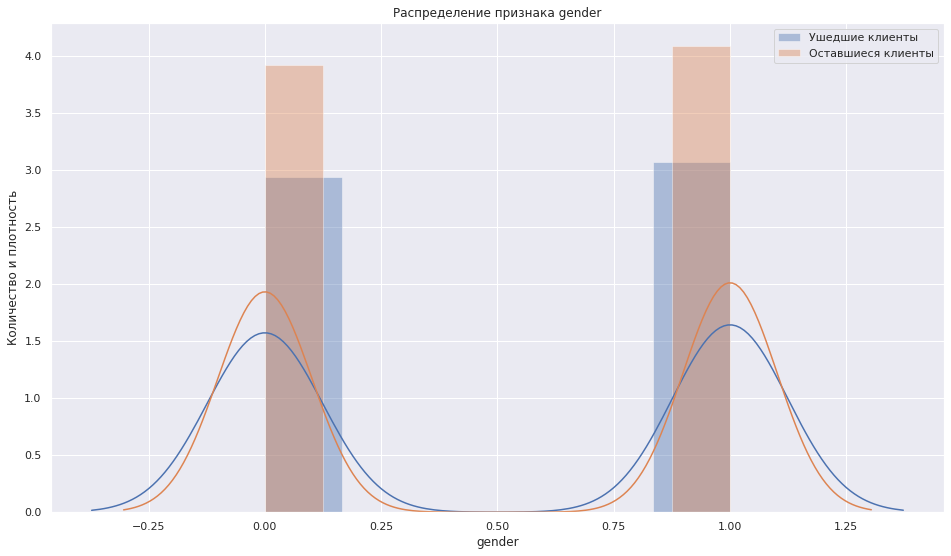

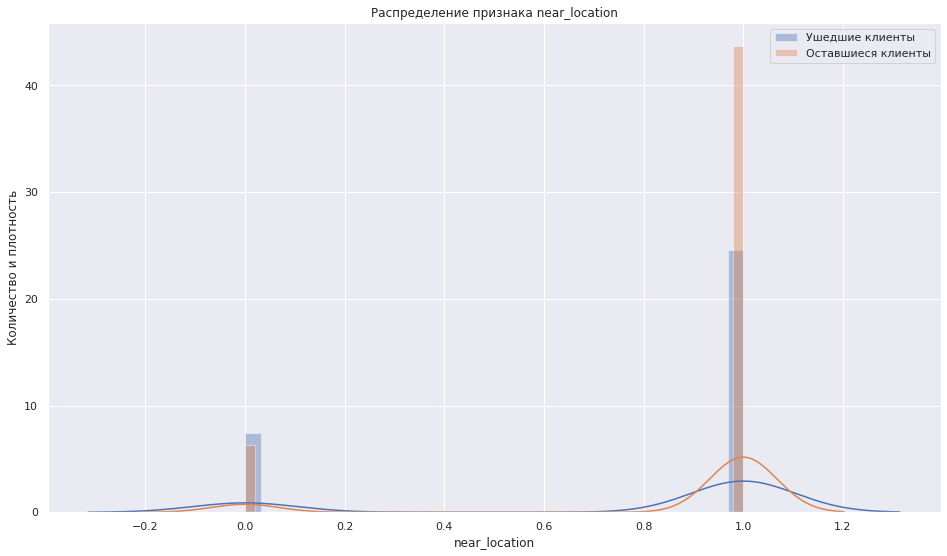

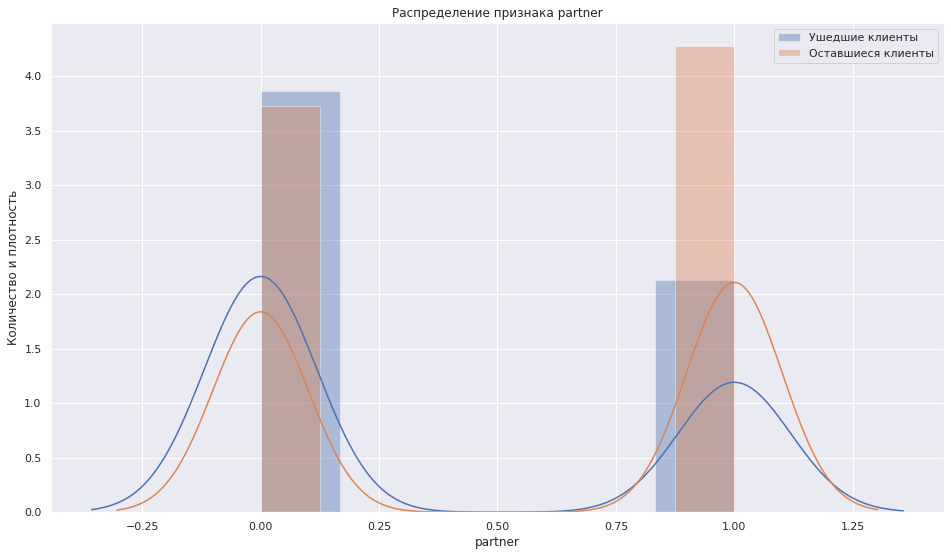

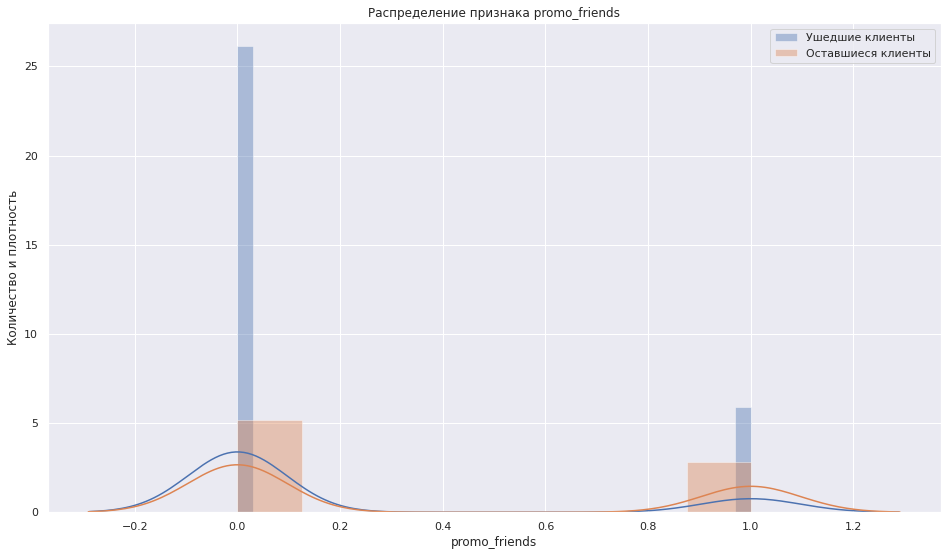

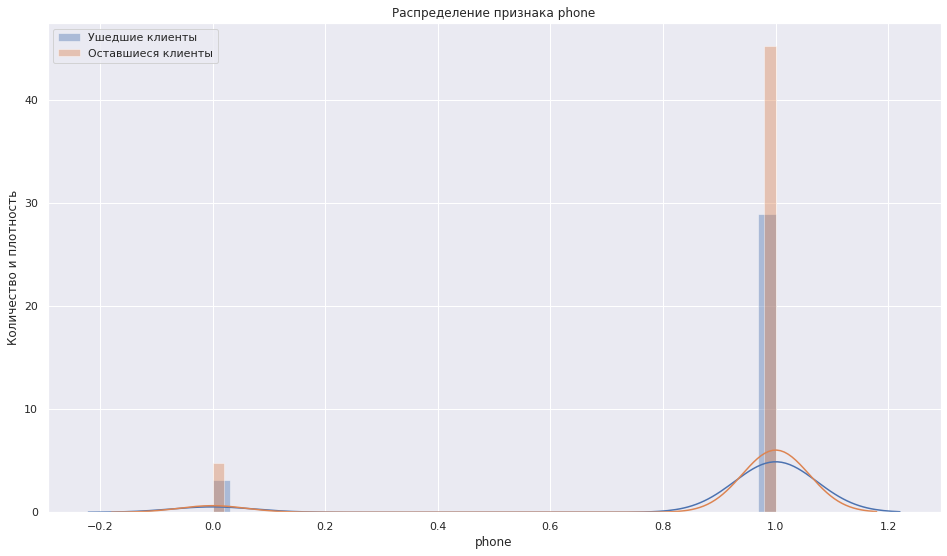

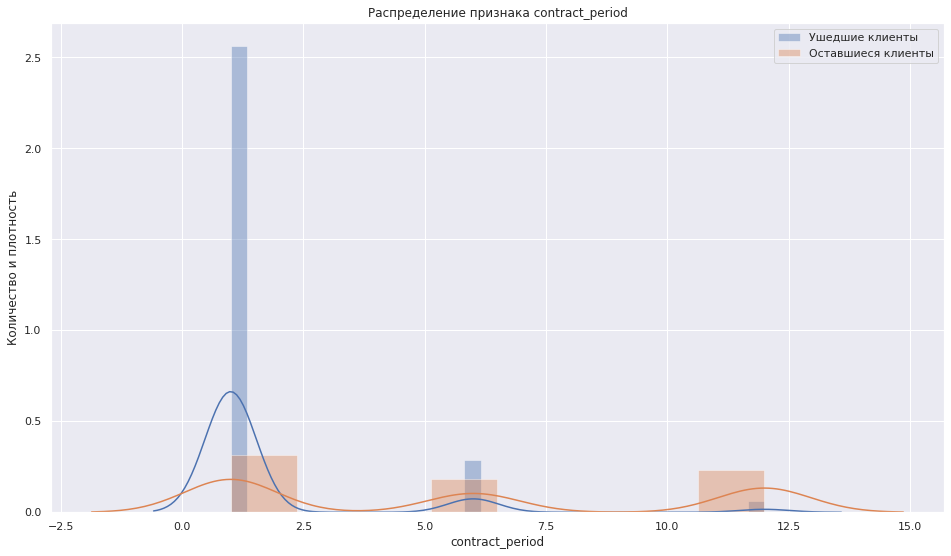

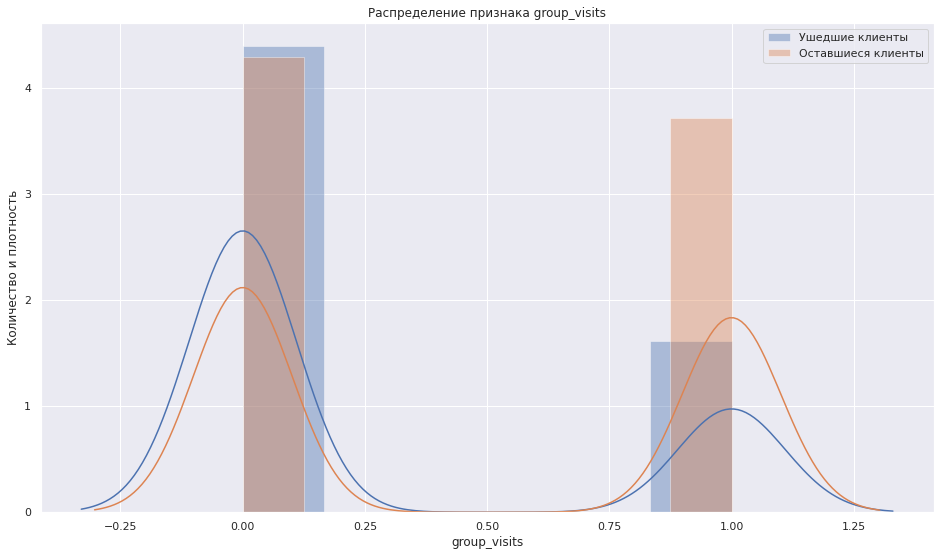

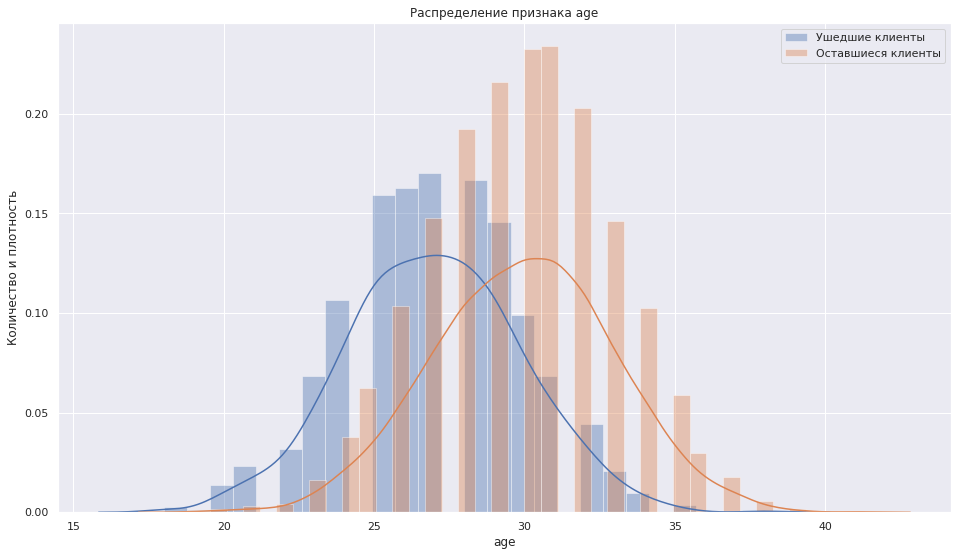

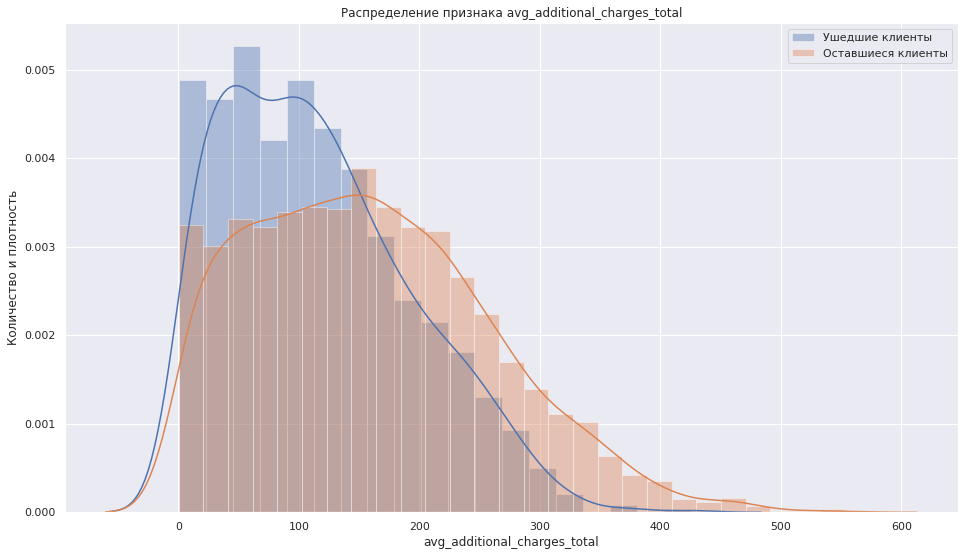

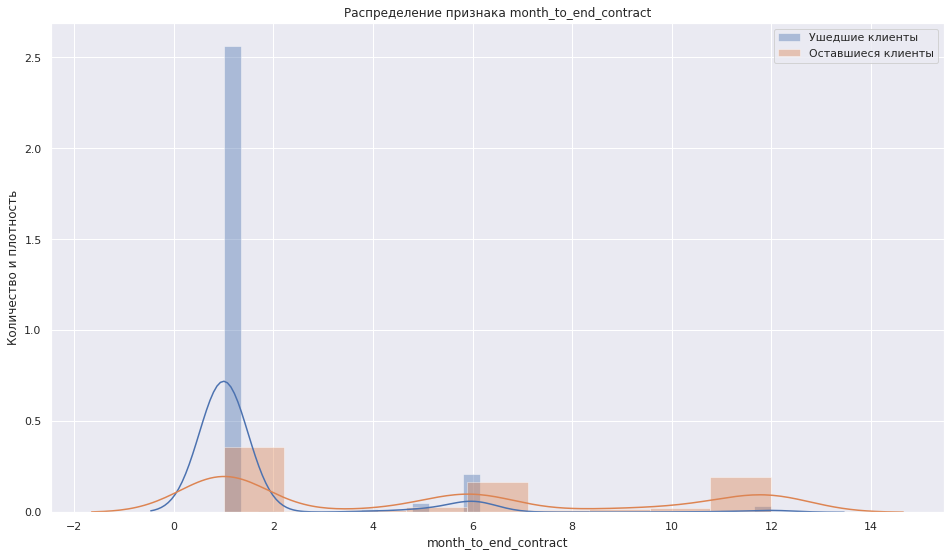

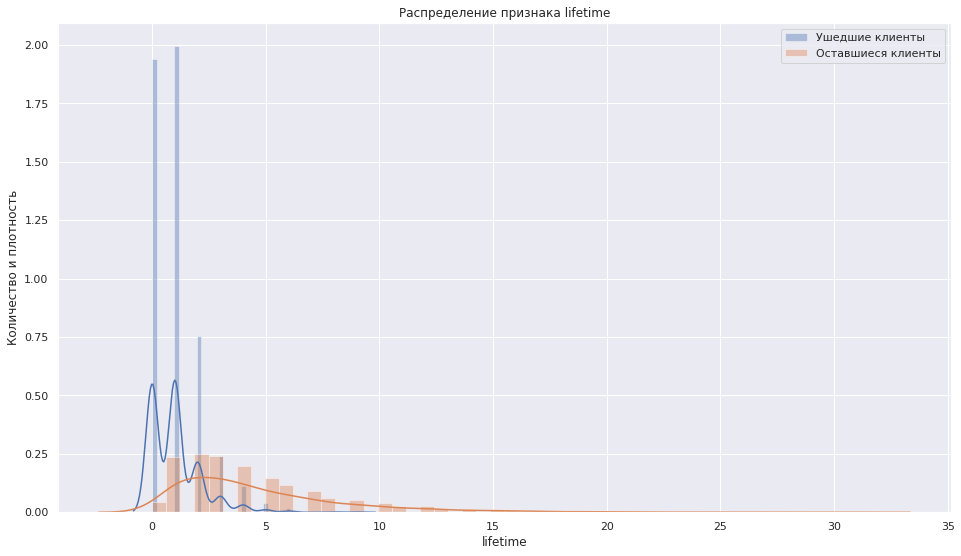

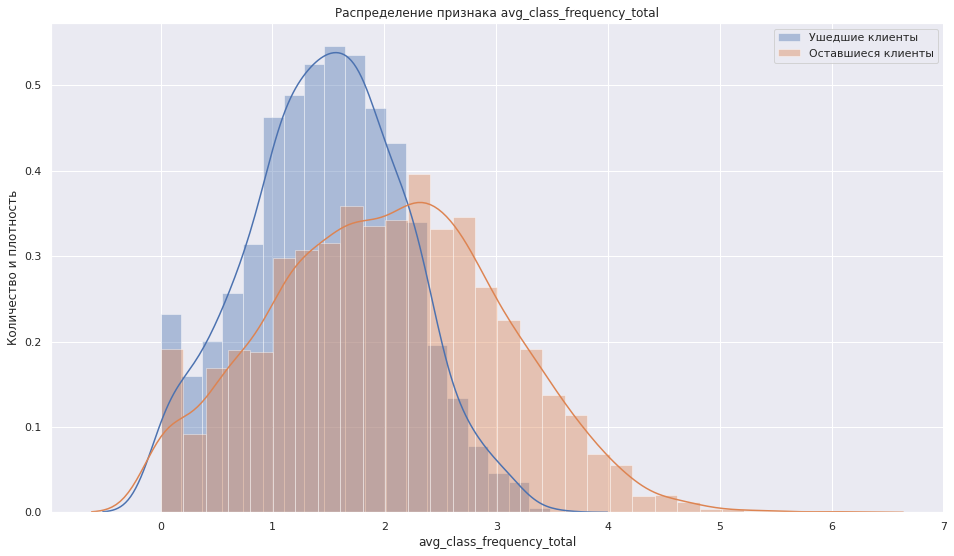

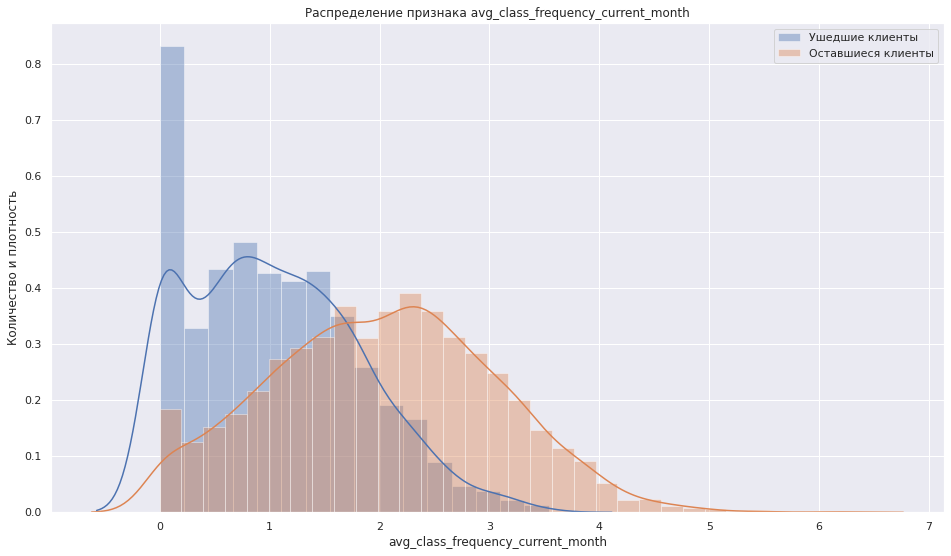

In [20]:
#Построим столбчатые гистограммы и распределения признаков для обоих групп
fig, ax = plt.subplots()
for column in data.drop('churn', axis = 1).columns:
    plt.title("Распределение признака "+column)
    plt.xlabel(column)
    plt.ylabel("Количество и плотность")
    sns.distplot(churn_clients[column], label='Ушедшие клиенты')
    sns.distplot(loyal_clients[column], label='Оставшиеся клиенты')
    plt.legend()
    plt.show()

На основании графиков можно подтвердить выводы выше:
* пол не является сильным фактором влияния на отток - распределение оставшихся и ушедших примерно равное
* те кто живут / работают рядом  уходят реже
* клиентов-сотрудников фирм партнером и обычных клиентов примерно одинаковое количество, но клиенты-сотрудники попадают в отток гораздо реже
* клиенты, воспользовавшиеся акцией "Пригласи друга" уходят в отток гораздо реже, чем те, кто пришли сами, но их больше, чем промо-клиентов
* распределение по признаку наличия номера телефона схожи
* распределение длительности действующего абонемента по оставшимся пользователям и ушедшим различается. Лояльных клиентов, приобретающих абонемент на 1 месяц больше всего, меньше их сроком на год, и наименьшее количество клиентов - на 6 месяцев. Для ушедших в отток 1 месяц - самый популярный, затем - 6 месяцев (с очень низким числом абонементов), и практически нет абонементов на 12 месяцев. 
* Клиенты, посещающие групповые занятия, уходят реже
* Более молодые клиенты готовы чаще отказываться от занятий (или менять фитнес-клуб), чем люди за 30
* Оставшиеся клиенты в среднем тратят больше на дополнительные услуги
* Наибольшее количество клиентов со сроком окончания контракта - 1 месяц, в отток чаще всего уходит именно эта группа
* Распределение по лайфтайму позволяет утверждать, что если клиент ходит более 6 месяцев, он врядли уйдет в отток
* Различия в распределении групп по сроку до окончания действующего абонемента такие же, как и в распределениях по длительности абонемента.
* Распределение для средней частоты посещений в неделю за время действия абонемента в обоих группах нормальное. Для лояльной группы оно немного смещено влево, а для группы уходящих в отток есть сильное смещение влево. Аналогичные различия между группами наблюдаются и для распределений средней частоты посещений в неделю за месяц

Частота оттока во многом зависит от социализации клиента в фитнес-клубе, а значит, приведенные выше визуализации зависимостей между "социальными" переменными могут служить хорошим фактором прогнозирования

### Матрица корреляций

Датафрейм содержит категориальные и количественные переменные, поэтому применить коэффициент корреляции Пирсона не получится. 
Воспользуемся другим инструментом - Phi_K коэффициент корреляции, основанный на нескольких уточнениях проверки гипотезы Пирсона о независимости двух переменных.
Совокупность признаков Phi_K дает преимущество перед существующими коэффициентами. 

Во-первых, он последовательно работает между категориальными, порядковыми и интервальными переменными. 

Во-вторых, он фиксирует нелинейную зависимость. 

В-третьих, он возвращается к коэффициенту корреляции Пирсона в случае двумерного нормального входного распределения. 

Это полезные функции при изучении корреляционной матрицы переменных со смешанными типами.

In [21]:
data.phik_matrix()


interval columns not set, guessing: ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'churn']


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00
near_location,0.00,1.00,0.00,0.32,0.00,0.09,0.24,0.07,0.12,0.19,0.06,0.06,0.07,0.20
partner,0.00,0.00,1.00,0.65,0.00,0.19,0.02,0.06,0.03,0.39,0.10,0.00,0.02,0.24
promo_friends,0.00,0.32,0.65,1.00,0.00,0.15,0.19,0.06,0.07,0.33,0.10,0.04,0.06,0.25
phone,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00
contract_period,0.00,0.09,0.19,0.15,0.00,1.00,0.10,0.16,0.14,0.97,0.20,0.15,0.18,0.25
group_visits,0.01,0.24,0.02,0.19,0.00,0.10,1.00,0.09,0.05,0.22,0.10,0.07,0.09,0.27
age,0.00,0.07,0.06,0.06,0.00,0.16,0.09,1.00,0.08,0.13,0.16,0.15,0.21,0.52
avg_additional_charges_total,0.00,0.12,0.03,0.07,0.00,0.14,0.05,0.08,1.00,0.13,0.01,0.09,0.06,0.26
month_to_end_contract,0.00,0.19,0.39,0.33,0.00,0.97,0.22,0.13,0.13,1.00,0.23,0.18,0.19,0.52


interval columns not set, guessing: ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'churn']


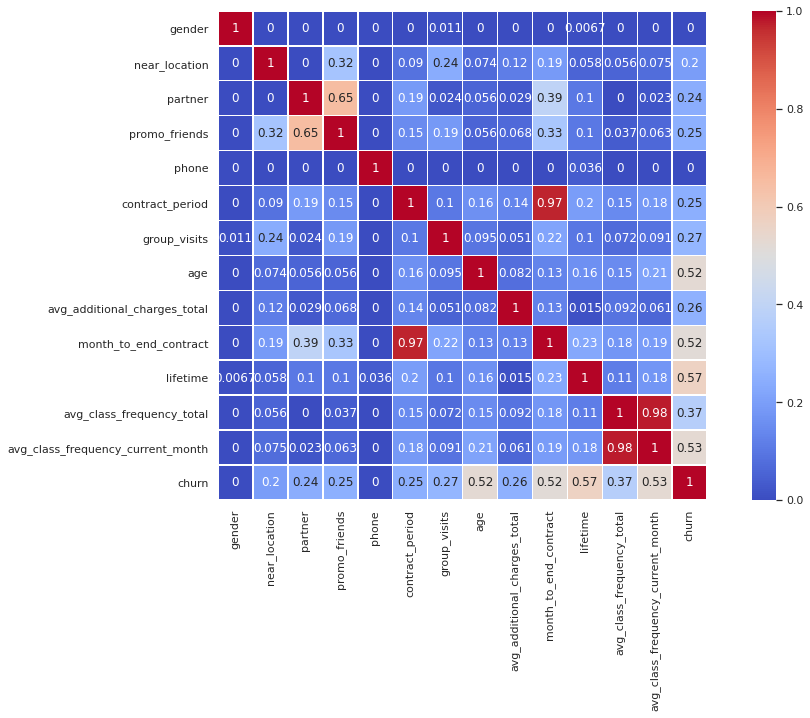

In [22]:
# get the phi_k correlation matrix between all variables

sns.heatmap(
    data.phik_matrix(), \
            square = True, annot = True, linewidths=.6, cmap='coolwarm' 
)
ax.set_ylim(14, 0)
plt.show()

Таким образом, самыми влиятельными факторами на отток можно признать:
* возраст (0,52)
* количество месяцев до окончания контракта (0,52)
* лайфтайм (0,57)
* среднее количество посещений в текущем месяце (0,53)

Наибольшая корреляция наблюдается между переменными:
* контрактный период и количество месяцев до окончания контракта (0,97)
* среднее количество посещений и среднее количество посещений в текущем месяце (0,98)
* участие в акции "Пригласи друга" и является ли клиент сотрудником фирмы-партнера (0,65)

Расположение фитнес-клуба влияет на то, участвует ли клиент в промо-акции и будет ли ходить на групповые занятия, а вот пол и наличие номера телефона не влияют практически ни на что


### Выводы по EDA

Исследовательский анализ данных (EDA) позволил сделать следующие выводы.

<b>Анализ показателей</b>

* Отток клиентов: доля оставшихся клиентов - 73,5%,  доля ушедших клиентов - 26,5%

* Пол клиентов. Мужчин и женщин примерно одинаковое количество. 
* Доля ушедших в отток и оставшихся -  распределение этого признака имеет аналогичный вид

* Близость к фитнес-центру. У нас имеются данные о людях, которые живут или работают рядом с фитнес-центром, либо в отдалённости от него. При этом в выборке больше тех, кто живёт или работает рядом (так как средняя близка к 0,85, а первый квартиль равен 1). А в группе, которая лояльна к фитнес-центру, чуть больше человек, которые живут или работают поблизости, чем тех, кто находится в отдалённости. Однако, распределения по этому признаку для лояльных и нелояльных клиентов не сильно отличаются друг от друга.

* Сотрудники компании-партнёра. Данные о людях, которые являются или не являются сотрудниками компании-партнёра клуба, представлены в выборке примерно в равной пропорции (средняя близка к 0,5). Есть различия в оттоке между теми, кто является сотрудником компании-партнёра клуба. Среди тех, кто остался примерно половина и тех, кто связан с партнёрами, и тех, кто не связан, с небольшим преобладанием первых. Но из тех, кто ушёл в отток, больше клиентов, не связанных с компанией-партнёром. Это же выражено и в распределении соответствующих данных.

* Промо-акция. Клиентов, которые приобрели первый абонемент не по промо-акции "Приведи друга" больше (так как средняя близка к 0,3, а медиана равна 0), но среди тех, кто остался, пришедших по промо-акции больше, хотя распределения у лояльных клиентов и ушедших близки

* Контактный телефон. В выборке больше тех, для кого представлена контактная информация (так как средняя близка к 0,9, а четвёртый квартиль равен 1) для обоих категорий: лояльных и нелояльных клиентов (распределения схожи).

* Возраст клиентов. Имеются данные о клиентах возрастом от 18 до 41 года. Средний возраст 29 лет, при этом люди разного возраста выбраны достаточно равномерно (так как средняя близка к медиане, распределение для лояльных и нелояльных клиентов нормальное, а стандартное отклонение очень низкое). В группе лояльных фитнес-центру людей средний возраст составляет около 30 лет, а среди уходящих - около 27 лет

* Время от покупки (активации) абонемента. Имеются данные о клиентах, которые начали посещать фитнес-центр впервые от 0 до 31 месяца назад (при этом нет клиентов, у которых прошло 25, 28 или 30 месяцев с момента первого обращения). Среднее время с момента первого обращения составляет 3 месяца. При этом есть перекос в данных, так как среднее значение ближе к 4 месяцам. Распределение времени с момента первого обращения для обоих групп (лояльных и нелояльных) похоже на распределение Пуассона. Но для ушедших в отток клиентов оно сильно смещено влево, практически не имея значения в более высоких значениях, а для лояльных клиентов принимает более высокие значения. Таким образом, среднее время с момента первого обращения для уходящих в отток составило 1 месяц, а для тех, кто остался, близко к 5 месяцам. 

* Длительность абонемента. Действующий абонемент по рассматриваемым клиентам имеет срок в 1, 6 и 12 месяцев (в выборку не попали клиенты, у которых срок составляет 3 месяца). Средняя длительность действующего абонемента составляет 4-5 месяцев. При этом есть перекос в данных: для большинства срок действующего абонемента равен 1 месяцу. Длительность действующего абонемента по оставшимся пользователям в среднем около 5-6 месяцев, а по ушедшим - 1-2 месяца. Это говорит о том, что купившие длительный абонемент с большей неохотой уйдут в отток, чем те, у кого он действует на короткий срок.

* Время до окончания абонемента. Имеются данные по клиентам, до окончания абонементов которых осталось от 1 до 12 месяцев. В среднем это значение около 4 месяцев. При этом больше половины всей выборки - это люди, до конца абонементов которых остался 1 месяц. Различия в распределении групп (лояльных и нелояльных клиентов) по сроку до окончания действующего абонемента такие же, как и в распределениях по длительности абонемента. В среднем срок до окончания действующего абонемента у людей, ушедших в отток, около 1-2 месяцев, а у оставшихся клиентов - около 5 месяцев. Это снова указывает на то, что уходят в большей степени те, у кого длительность оставшегося абонемента невысока.

* Групповые занятия. В выборке чуть больше тех, кто не посещает такие занятия (средняя близка к 0,4, а медиана равна 0). При этом среди лояльных клиентов распределение посещающих такие занятия и не посещающих примерно равномерно (вторых чуть больше); но среди тех, кто ушёл в отток, непосещающих групповые занятия значительно больше, чем тех, кто их посещает.

* Частота посещений за весь срок. Имеются данные по клиентам со средней частотой посещений за все время с начала действия абонемента от 0 до 6 раз в неделю. В среднем это значение составляет около 2 раз в неделю. При этом выборка равномерная, так как среднее почти равно медиане, а стандартное отклонение невысоко. Распределение для средней частоты посещений в неделю за время действия абонемента в обоих группах (лояльные и нелояльные клиенты) является нормальным. Для лояльной группы оно немного смещено влево, а для группы уходящих в отток имеется сильное смещение влево. Лояльные клиенты, в среднем, посещают центр 2 раза в неделю, а ушедшие - от 1 до 2.

* Частота посещений за месяц. Имеются данные по клиентам со средней частотой посещений за месяц от 0 до 6 раз в неделю. В среднем это значение составляет около 2 раз в неделю. Распределения и средние значения схожи с распределениями аналогичного показателя за весь срок абонемента.

* Выручка от прочих услуг. Выручка от прочих услуг фитнес-центра с клиента составила от 0,15 до 552,6 ден.ед. В среднем это значение составляет около 147 ден.ед., медиана равна 136 ден.ед. Разброс данных очень большой (мы не знаем точно, в каких ден.ед. измеряются данные). Средняя выручка от других услуг фитнес-центра между группами разнится на 43 ден.ед. (в группе лояльных она выше, чем в группе уходящих). Распределение средней выручки от других услуг фитнес-центра для обоих датасетов смещено влево с большим смещением для ушедших людей, то есть те, кто уходит, стараются минимизировать затраты на дополнительные услуги в фитнес-центре.

На основе корреляции видно, что такие признаки как пол и наличие контактного телефона почти не влияют на конечный показатель оттока. 

Все остальные показатели имеют обратное влияние: слабое, либо чуть более сильное. 

Самыми влиятельными факторами на отток можно признать:

- возраст (0,52)
- количество месяцев до окончания контракта (0,52)
- лайфтайм (0,57)
- среднее количество посещений в текущем месяце (0,53)

Наибольшая корреляция наблюдается между переменными:
- контрактный период и количество месяцев до окончания контракта (0,97)
- среднее количество посещений и среднее количество посещений в текущем месяце (0,98)
- участие в акции "Пригласи друга" и является ли клиент сотрудником фирмы-партнера (0,65)

## Модель прогнозирования оттока клиентов

 Модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце

Наблюдается сильная связь между средней частотой посещений в неделю с начала пользования услугами и за предыдущий месяц. Это говорит о зависимости - клиенты посещают фитнес-центр примерно одинаковое число раз в неделю вне зависимости от того, сколько они пользуются услугами центра. 

Это же касается и  длительности абонемента и количеством месяцев до конца абонемента. Скорее всего в выборке представлены клиенты, которые отобраны на определённом этапе покупки абонемента, например, в начале действия абонемента

In [23]:
#  удалим эти признаки из модели  
data = data.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1)

In [24]:
# разделим  данные на признаки (матрица X) и целевую переменную (y)
X = data.drop('churn', axis = 1)
y = data['churn']

# разделяем модель на обучающую и валидационную выборки в соотношении 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
# обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_train_st = scaler.fit_transform(X_train)
# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

In [25]:
# определим функцию, которая будет выводить метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    # доля правильных ответов из всего прог<div class="alert alert-info"> <b>Комментарий студента: ℹ️</b> Оптимизировала. Спасибо!</div>ноза
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    # точность - доля правильных ответов среди целевого класса
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    # показатель обнаружения реальных объектов "1" класса моделью
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    # сводная метрика, учитвающая баланс между метриками
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    # метрика оценки качества классификатора 
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [26]:
# обучение по алгоритму логистической регрессии

# задаем алгоритм
lr_model = LogisticRegression(solver='liblinear', random_state=0, class_weight='balanced') 
# обучение модели
lr_model.fit(X_train_st, y_train)
#  бинарный прогноз для объектов из валидационного набора данных
lr_predictions = lr_model.predict(X_test_st) 
# оценка вероятности принадлежности ко второму классу (среди классов 0 и 1 - принадлежность к классу 1)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1] 

In [27]:
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.74
	Recall: 0.94
	F1: 0.83
	ROC_AUC: 0.97


В данной модели приоритетной метрикой является метрика Recall. По алгоритму логистической регрессии эта метрика составляет 0,93 - отличный уровень.
Проверим, какое значение Recall получится при применении обучения по алгоритму "Случайный лес"

In [28]:
# обучение по алгоритму "Случайный лес"

# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0) # Ваш код здесь
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)# Ваш код здесь
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]# Ваш код здесь
# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)


Метрики для модели случайного леса:
	Accuracy: 0.91
	Precision: 0.85
	Recall: 0.77
	F1: 0.81
	ROC_AUC: 0.96


Recall: 0.75 - этот результат хуже, чем в алгоритме логистической регрессии

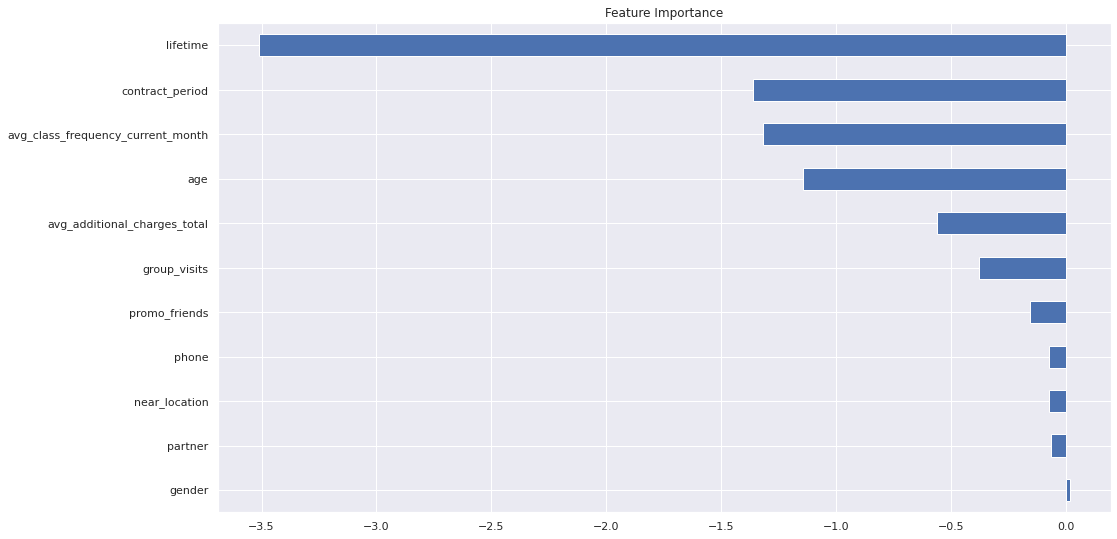

In [29]:
# обучим финальную модель

final_model = LogisticRegression(solver='liblinear', random_state=0, class_weight='balanced') 
final_model.fit(X_train_st, y_train)
y_pred = final_model.predict(X_test_st)

# коэффициенты регрессии хранятся в атрибуте обученной модели .coef_ :
importance = final_model.coef_[0]
#importance is a list so you can plot it. 
feat_importances = pd.Series(importance, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh',title = 'Feature Importance')
plt.show()

In [30]:
# важность коэффициентов модели
feature_results = pd.DataFrame({'feature': X.columns, 'importance': importance})
feature_results.sort_values(by='importance', ascending=True)

,feature,importance
9,lifetime,-3.51
5,contract_period,-1.36
10,avg_class_frequency_current_month,-1.32
7,age,-1.15
8,avg_additional_charges_total,-0.56
6,group_visits,-0.38
3,promo_friends,-0.16
4,phone,-0.08
1,near_location,-0.07
2,partner,-0.07


Наиболее важными признаками оказались:
* lifetime
* avg_class_frequency_current_month
* contract_period
* age

Все они со знаком "минус": увеличение этих коэффициентов уменьшает целевую переменную, т.е. снижает вероятность оттока клиента

In [31]:
# Расчёт точности, полноты, F-меры и носителя
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93       588
           1       0.74      0.94      0.83       212

    accuracy                           0.90       800
   macro avg       0.86      0.91      0.88       800
weighted avg       0.91      0.90      0.90       800



Из всех клиентов, которые предсказывала модель, 70% ушли в отток.

Из всех клиентов, которые действительно ушли, модель правильно предсказала этот результат для 93% этих клиентов.

Оценка F1 80% - в целом, модель хорошо предсказывает, уйдут ли клиенты в отток.

Поддержка: эти значения просто говорят нам, сколько клиентов принадлежало к каждому классу в тестовом наборе данных 602 не ушли, 198 ушли


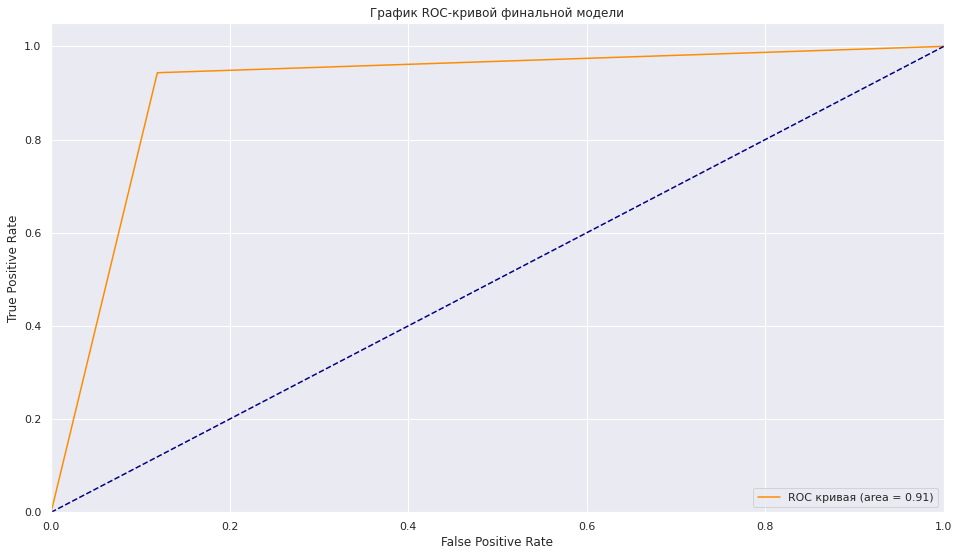

In [32]:
# ROC-кривая

fpr, tpr, _ = metrics.roc_curve (y_test, y_pred)
auc = metrics.roc_auc_score (y_test, y_pred)
#create ROC curve
plt.plot (fpr,tpr, color='darkorange', label='ROC кривая (area = %0.2f)' % auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc=4)
plt.title('График ROC-кривой финальной модели')
plt.show() 


Чем больше кривая охватывает верхний левый угол графика, тем лучше модель классифицирует данные по категориям.

Как видно из графика выше, эта модель логистической регрессии довольно хорошо справляется с классификацией данных по категориям.

Чтобы дать количественную оценку, мы можем рассчитать AUC — площадь под кривой, которая говорит нам, какая часть графика расположена под кривой.

Чем ближе AUC к 1, тем лучше модель. Модель со значением AUC, равным 0,9 отлично справляется с классификацией

<b> Выводы</b>

При построении модели выборка была разделена на обучающую и валидационную в соотношении 80 к 20, то есть на 80% данных модель была обучена, а на 20% - проверена. После этого были построены и обучены две модели - алгоритмом логистической регрессии и алгоритмом случайного леса. Лучшей была признана модель по алгоритму логистической регрессии (приоритетная метрика Recall для нее составила 0,93, для "случайного леса" - 0,75). Значение AUC для финальной модели составило 0,9, что свидетельствует о том, что модель справляется с классификацией хорошо.

Наиболее важными признаками-коэффициентами модели оказались: lifetime, avg_class_frequency_current_month, contract_period, age. Все они со знаком "-": при их увеличении, целевое значение будет снижаться

## Кластеризация клиентов

### Построение матрицы расстояний и дендрограммы

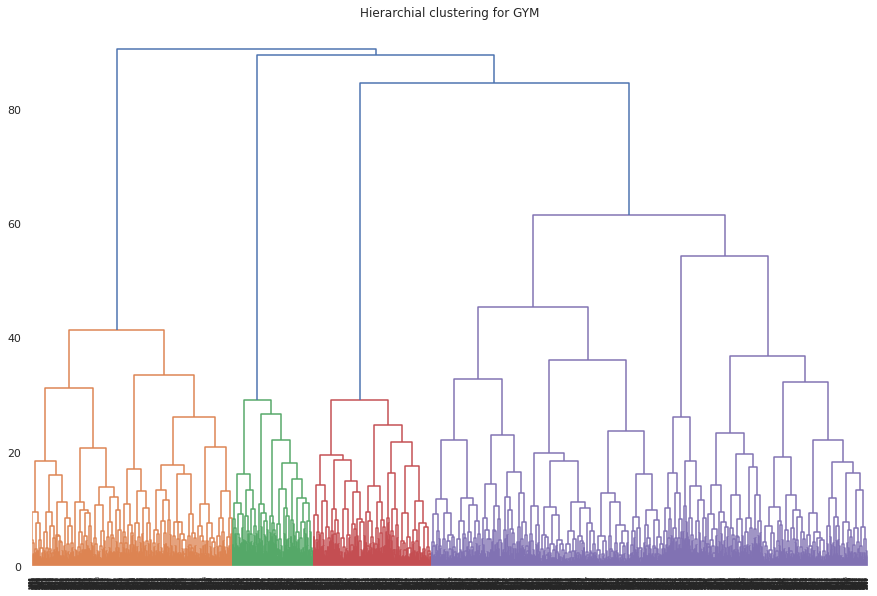

In [33]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# Сохраним матрицу расстояний
linked = linkage(X_sc, method = 'ward') 
# Построим дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show() 

Предложенное оптимальное число кластеров 4 — четыре разных цвета на графике.
После оценки оптимального числа кластеров запустим более быстрый алгоритм K-Means.

### Обучение модели кластеризации и прогноз кластеров клиентов

Было принято решение для прогноза кластеров клиентов использовать пять кластеров. Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

In [34]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
data['cluster_km'] = labels


# Переименуем названия кластеров
data.loc[data['cluster_km']==0, 'cluster_km'] = 'cluster_1'
data.loc[data['cluster_km']==1, 'cluster_km'] = 'cluster_2'
data.loc[data['cluster_km']==2, 'cluster_km'] = 'cluster_3'
data.loc[data['cluster_km']==3, 'cluster_km'] = 'cluster_4'
data.loc[data['cluster_km']==4, 'cluster_km'] = 'cluster_5'

# Выведем средние значения признаков для кластеров
data.groupby('cluster_km').mean().T

cluster_km,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
gender,0.50,0.50,0.50,0.53,0.52
near_location,1.00,0.00,1.00,1.00,0.86
partner,0.89,0.49,0.22,0.38,0.47
promo_friends,1.00,0.08,0.07,0.01,0.31
phone,1.00,1.00,1.00,1.00,0.00
contract_period,6.92,2.99,2.01,6.21,4.78
group_visits,0.52,0.23,0.28,0.54,0.43
age,29.61,28.68,27.58,30.70,29.30
avg_additional_charges_total,153.42,137.13,119.34,176.26,144.21
lifetime,4.28,2.97,1.92,5.42,3.94


### Анализ распределения признаков для кластеров

Для анализа распределения признаков в кластерах построим столбчатые диаграммы для логических и дискретных переменных (пол, близость к фитнес-центру, принадлежность к компании-партнёру, первое посещение по акции "Приведи друга", наличие контакта, длительность абонемента, посещение групповых занятий, отток) и боксплоты для непрерывных переменных (возраст, время с момента первого обращения, показатели средней частоты посещений в неделю за месяц, выручка от других услуг).

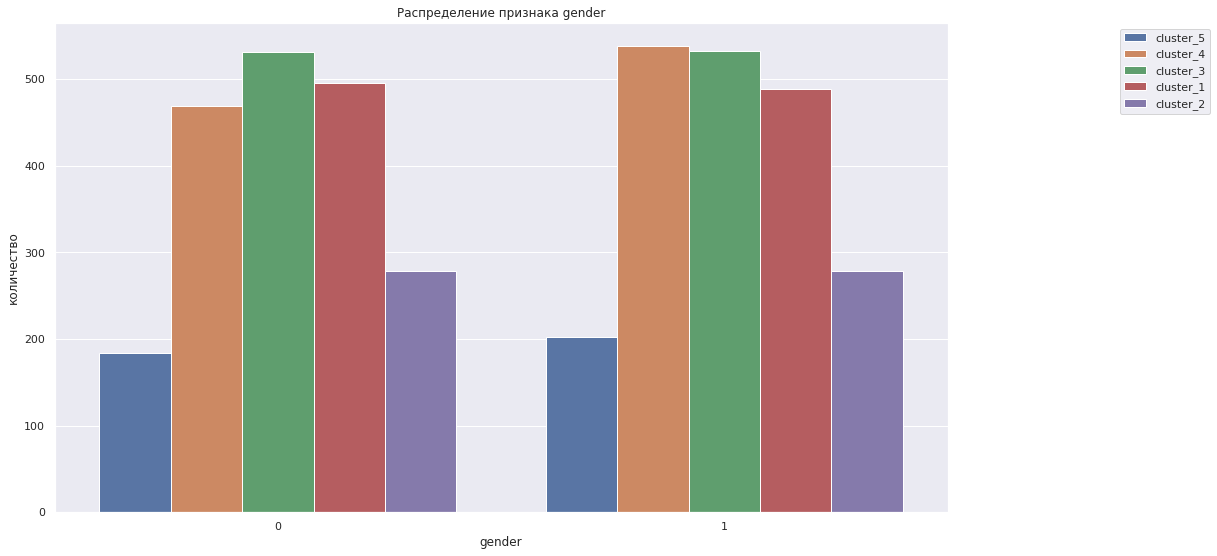

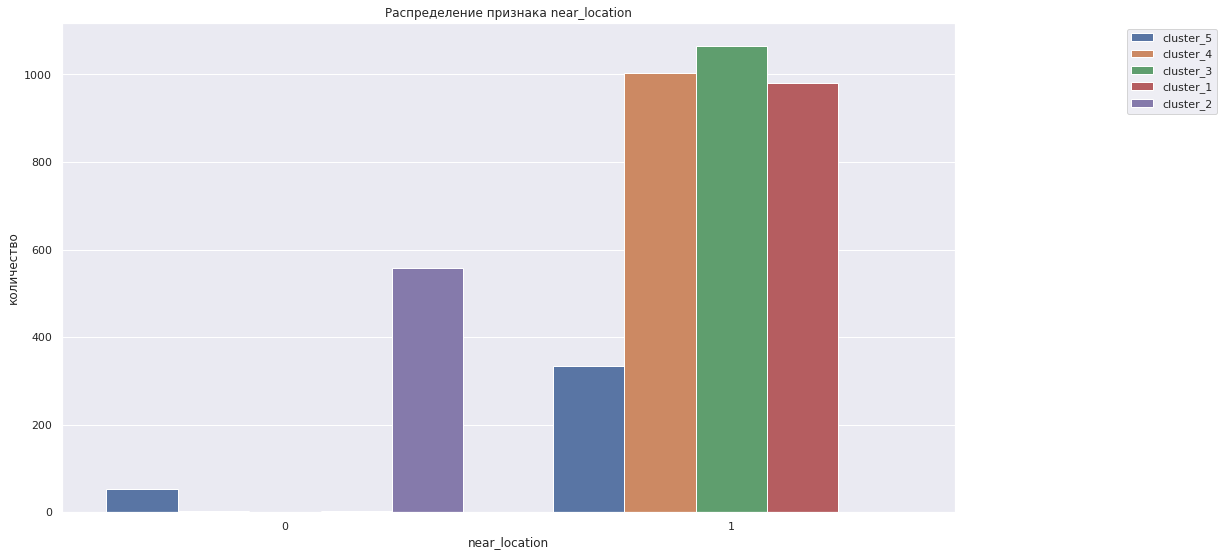

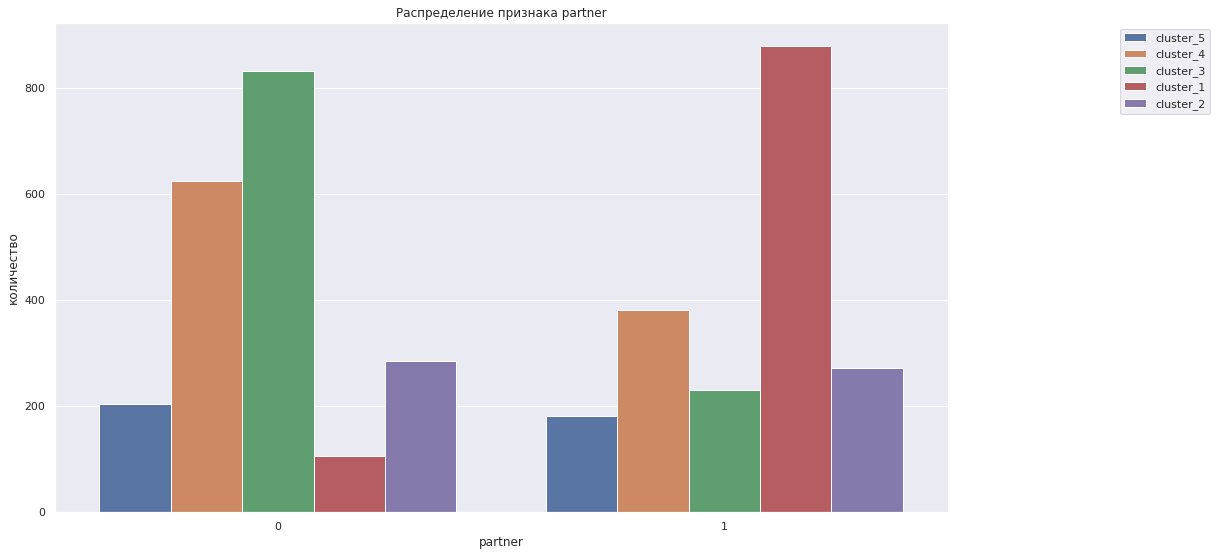

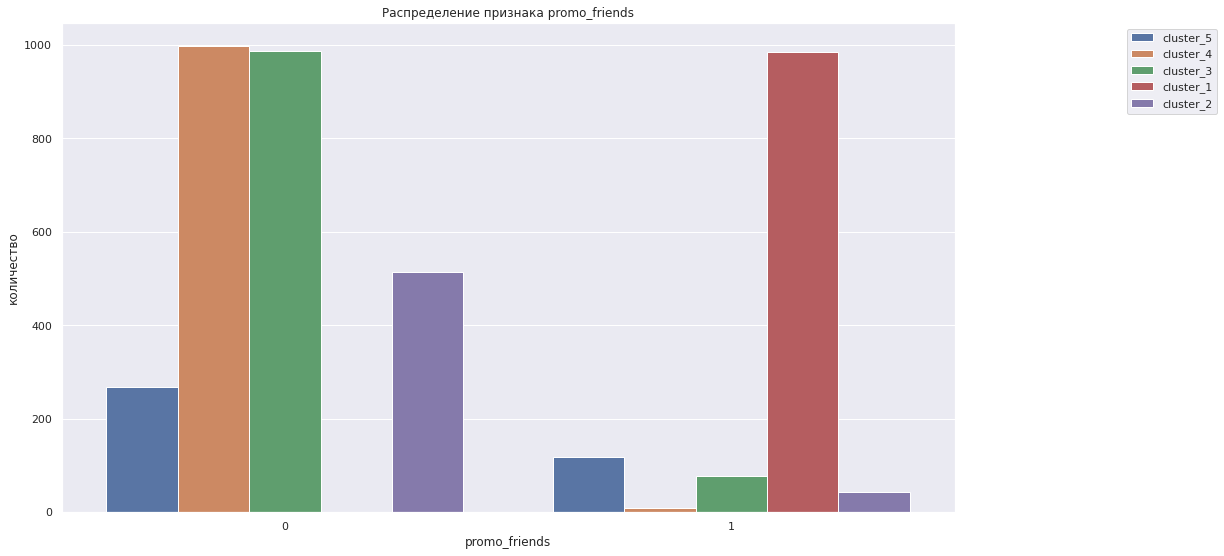

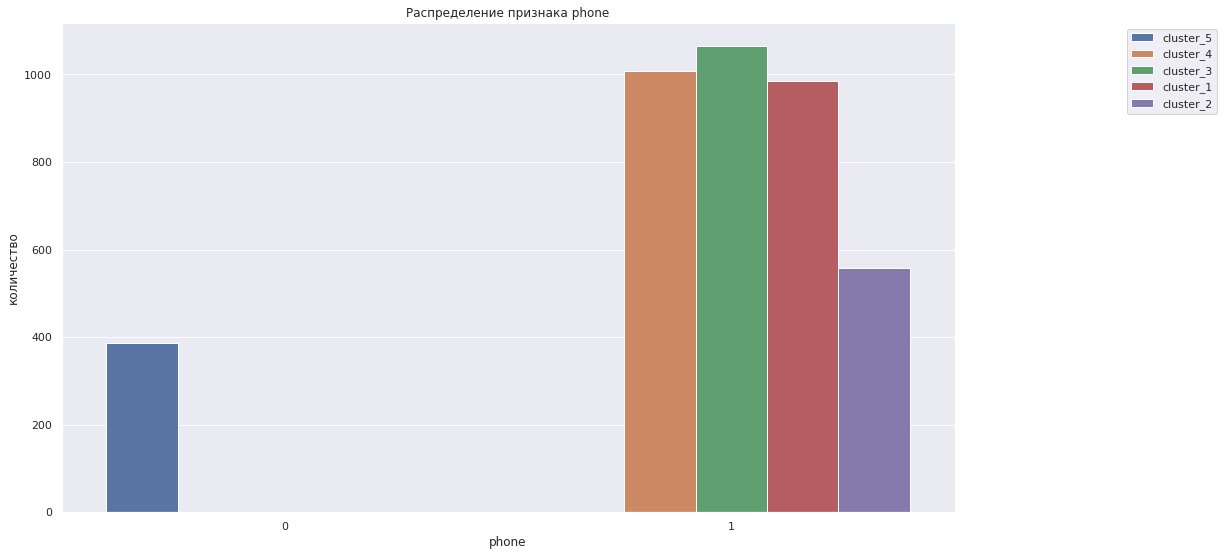

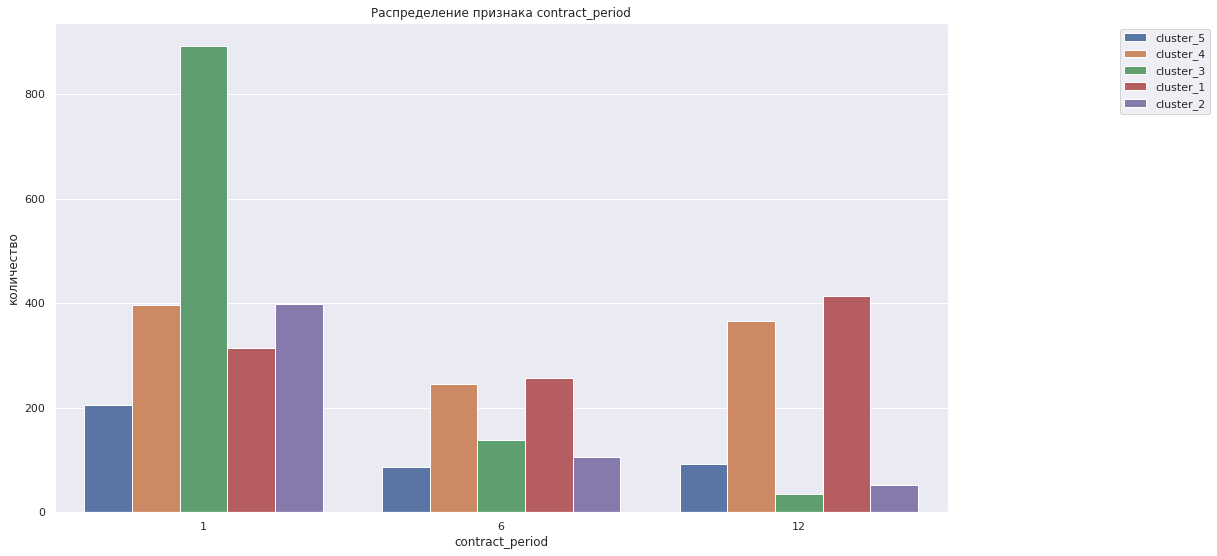

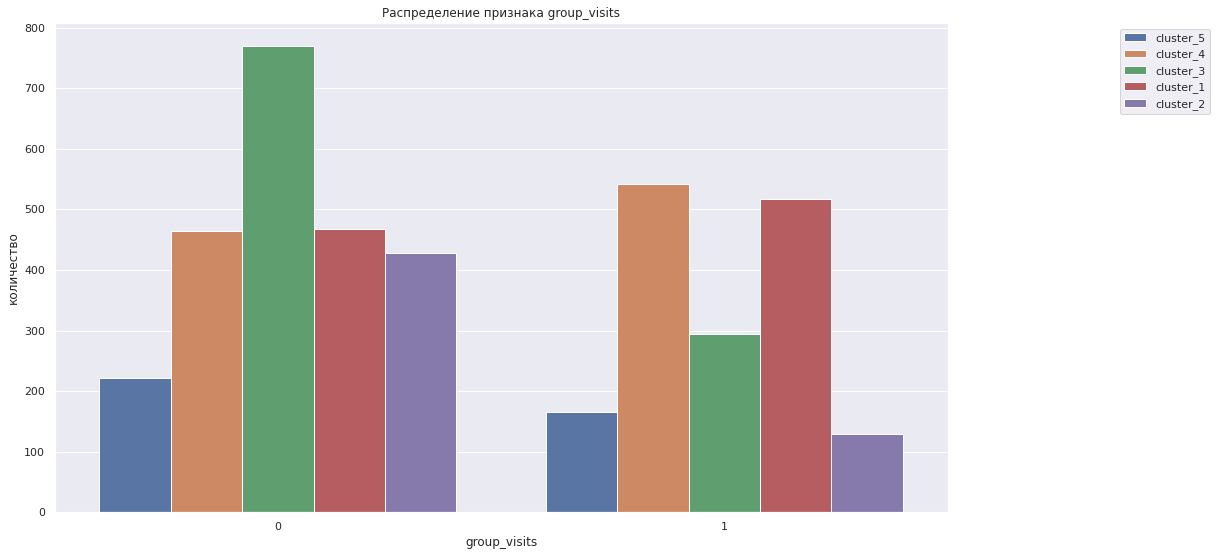

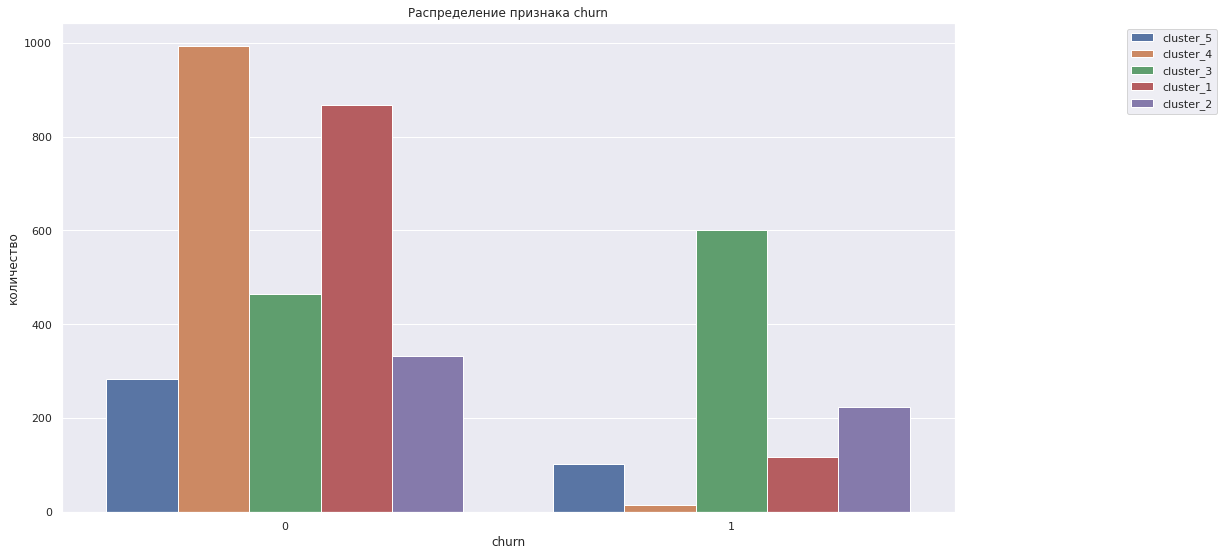

In [35]:
# Построим график для логических и дискретных величин
log_discr_values = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'churn']
fig, ax = plt.subplots()
for column in log_discr_values:
    plt.title("Распределение признака "+column)
    sns.countplot(data=data, x=column, hue='cluster_km')
    plt.xlabel(column)
    plt.ylabel("количество")
    plt.legend(bbox_to_anchor=(1.3, 1))
    plt.show()

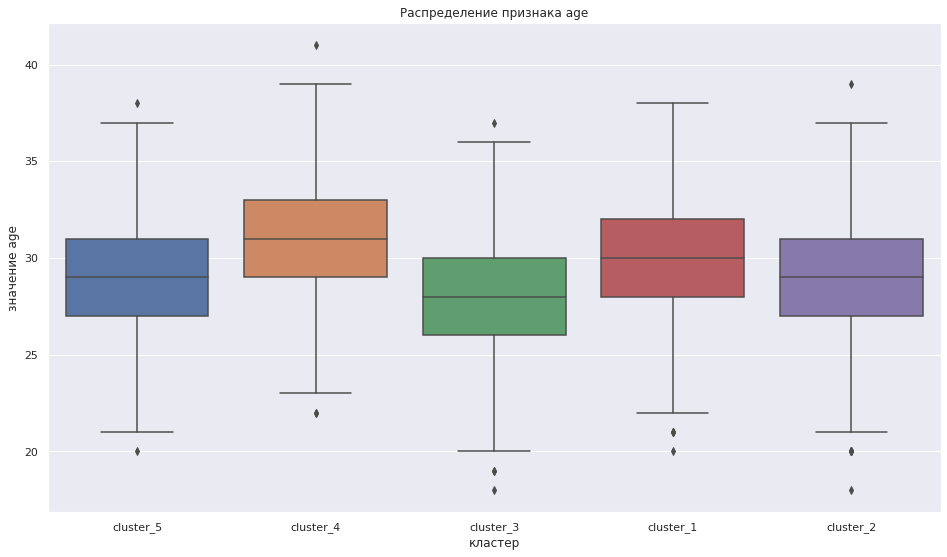

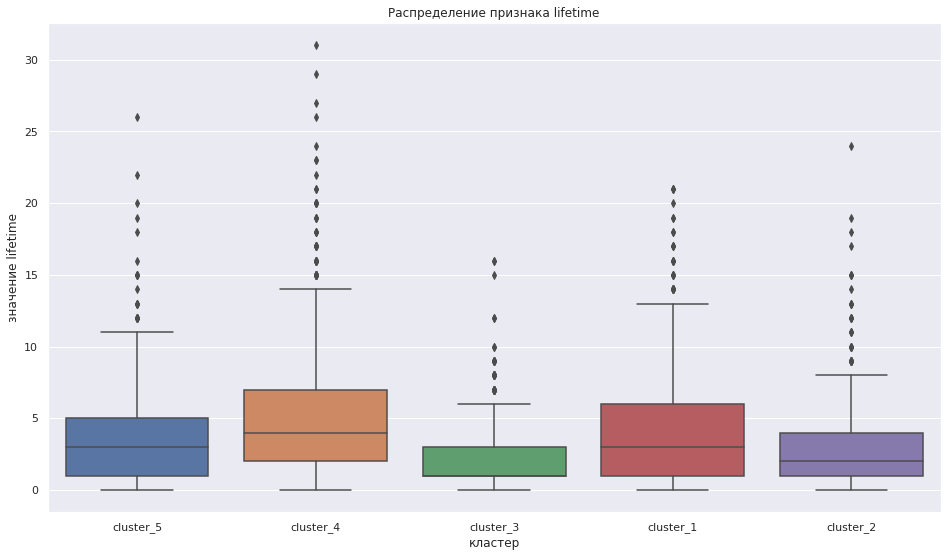

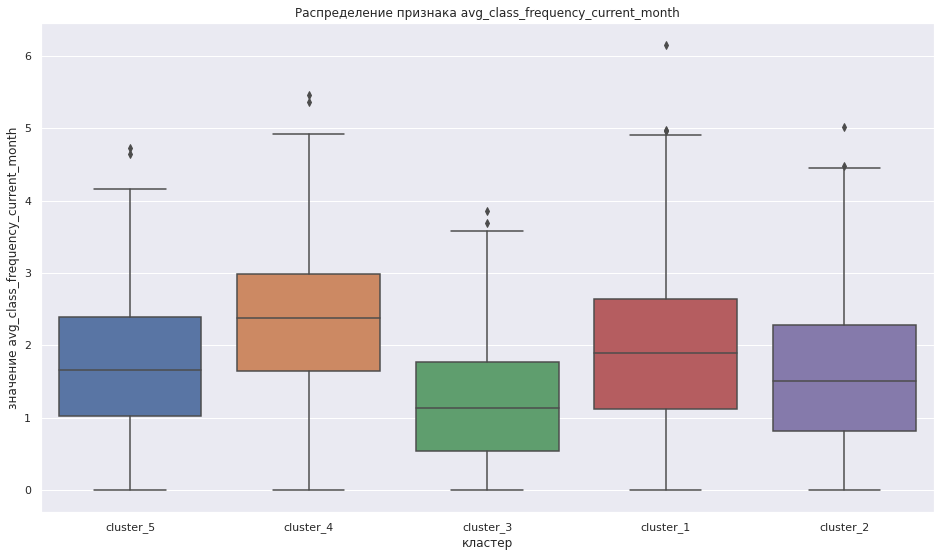

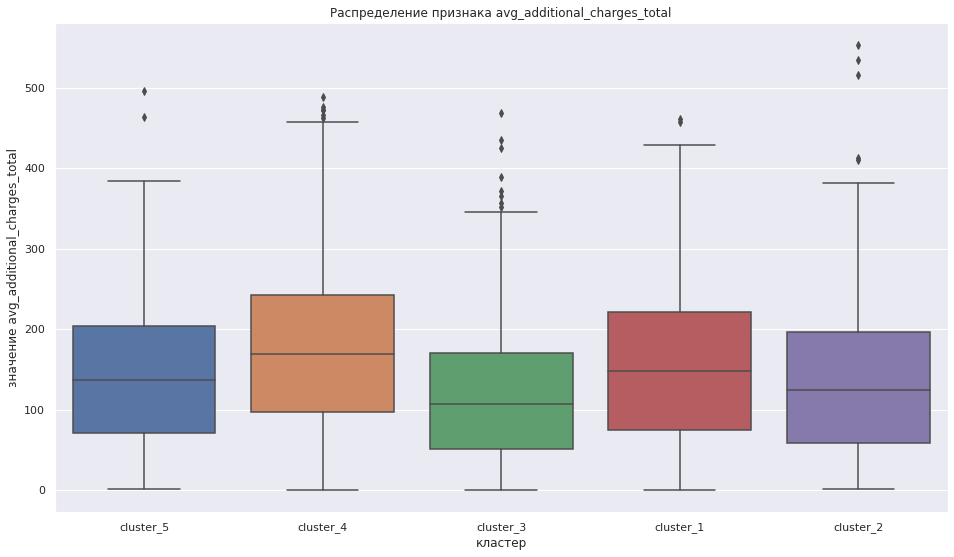

In [36]:
# Построим график для непрерывных величин
cont_values = ['age', 'lifetime', 'avg_class_frequency_current_month', 'avg_additional_charges_total']
fig, ax = plt.subplots()
for column in cont_values:
    plt.title("Распределение признака "+column)
    sns.boxplot(x='cluster_km', y=column, data=data)
    plt.xlabel('кластер')
    plt.ylabel('значение '+column)
    plt.show()

<b> Характеристика кластера 1</b>
* Пол: мужчин и женщин примерно равное количество
* Расположение относительно фитнес-центра: среднее расстояние 1 км
* Соотношение клиентов по признаку принадлежности к фирмам-партнерам: <b><i>около 80% являются сотрудниками фирм-партнеров</i></b>
* Участники акции «Приведи друга»: <b><i>100% клиентов воспользовались предложением</i></b>
* Наличие номера телефона: 100%
* Контрактный период: абонементы  на 1, 6 и 12 месяцев с распределением долей 31%, 26%, 43% 
* Посещение групповых занятий: <b><i>52% посещает</i></b>	
* Средний возраст: 30 лет
* Срок от начала пользования услуг: средний
* Среднее количество посещений в текущем месяце: около 2-х раз в неделю
* Затраты на дополнительные услуги: средние
* <u>Отток клиентов: <i>12%</i></u>

<b>Характеристика кластера 2</b>
* Пол: мужчин и женщин примерно равное количество
* Расположение относительно фитнес-центра: <b><i>в том же здании</i></b>
* Соотношение клиентов по признаку принадлежности к фирмам-партнерам: примерно одинаковое
* Участники акции «Приведи друга»: <b><i>92% клиентов не воспользовались предложением</i></b>
* Наличие номера телефона: 100%
* Контрактный период: абонементы  на 1, 6 и 12 месяцев с преобладанием абонементов на <b><i>1 месяц (около 70%)</i></b>
* Посещение групповых занятий: <b><i>77% не посещает</i></b>
* Средний возраст: 29 лет
* Срок от начала пользования услуг: <b><i>короткий</i></b>
* Среднее количество посещений в текущем месяце: 1-2 раза в неделю
* Затраты на дополнительные услуги: средние
* <u>Отток клиентов: <b>40%</b></u>

<b>Характеристика кластера 3</b>
* Пол: мужчин и женщин примерно равное количество
* Расположение относительно фитнес-центра: среднее расстояние 1 км
* Соотношение клиентов по признаку принадлежности к фирмам-партнерам: <b><i>78% клиентов не являются сотрудниками фирм-партнеров</i></b>, 22% - являются
* Участники акции «Приведи друга»: <b><i>93% клиентов не воспользовались предложением</i></b>
* Наличие номера телефона: 100%
* Контрактный период: абонементы  на 1, 6 и 12 месяцев с преобладанием абонементов на <b><i>1 месяц (около 80%)</i></b>
* Посещение групповых занятий: <b><i>72% не посещает</i></b>
* Средний возраст: 28 лет
* Срок от начала пользования услуг: <b><i>короткий</i></b>
* Среднее количество посещений в текущем месяце: около 1 раза в неделю
* Затраты на дополнительные услуги: <b><i>низкие</i></b>
* <u>Отток клиентов: <b>56%</b></u>

<b>Характеристика кластера 4</b>
* Пол: мужчин и женщин примерно равное количество
* Расположение относительно фитнес-центра: среднее расстояние 1 км
* Соотношение клиентов по признаку принадлежности к фирмам-партнерам: 62% клиентов не являются сотрудниками фирм-партнеров, 38% - являются
* Участники акции «Приведи друга»: <b><i>99% клиентов не воспользовались предложением</i></b>
* Наличие номера телефона: 100%
* Контрактный период: абонементы  на 1, 6 и 12 месяцев с распределением долей 39%, 26%, 35% 
* Посещение групповых занятий: <b><i>54% посещает</i></b>	
* Средний возраст: 31 год
* Срок от начала пользования услуг: <b><i>длительный</i></b>	
* Среднее количество посещений в текущем месяце: 1-3 раза в неделю
* Затраты на дополнительные услуги: <b><i>высокие</i></b>
* <u>Отток клиентов: <i>1%</i></u>

<b>Характеристика кластера 5</b>
* Пол: мужчин и женщин примерно равное количество
* Расположение относительно фитнес-центра: среднее расстояние 0,86 км (присутствуют клиенты из того же здании и находящиеся на определенном расстоянии)
* Соотношение клиентов по признаку принадлежности к фирмам-партнерам: примерно одинаковое
* Участники акции «Приведи друга»: <b><i>69% клиентов не воспользовались предложением</i></b>, 31% - воспользовались
* Наличие номера телефона: 0%
* Контрактный период: абонементы  на <b><i>1</i></b>, 6 и 12 месяцев с распределением долей <b><i>50%</i></b>, 24%, 26% 
* Посещение групповых занятий: 43% посещает
* Средний возраст: 29 лет
* Срок от начала пользования услуг: средний
* Среднее количество посещений в текущем месяце: 1-2 раза в неделю
* Затраты на дополнительные услуги: средние
* <u>Отток клиентов: 27%</u>

<b>Выводы</b>

По матрице-расстояний и дендограмме выделено четыре основных кластера, но для большей точности, используя алгоритм К-средних, были выделены пять кластеров, основные характеристики которых приведены выше. Самым ненадежным кластером признан кластер №3 (отток 56%), а самый надежный - кластер №4 (отток 1 %)

## Выводы и базовые рекомендации по работе с клиентами

* Акция "Приведи друга" не является универсальным средством борьбы с оттоком клиентов: в кластере с наименьшим значением оттока (1%) 99% клиентов не воспользовались данным предложением, точно так же, как и в кластере с наимбольшим значением оттока (56%). Данная акция хорошо сработала только в кластере, на 80% состоющим из клиентов - сотрудников фирм-партнеров. Вероятно, этот сегмент является излишним для данной акции, потому что фирмы-партнеры и так распространяют абонементы среди своих сотрудников или коллеги могут поделится отзывами о занятиях в фитнес-клубах. <i>Лучше направить рекламный бюджет на листовки и баннеры в ближайших районах</i>.

* Социализация клиента в фитнес-клубе - важнейшая и незатратная задача, которую можно решить путём <i>проведения соревнований (командных и персональных), праздников (например, фитнес-танцевальные вечеринки, занятие в парке), рейтингом клиентов в приложении, например, по различным категориям (поднятие веса, скинутые кг)</i>

* Необходимо перезапустить промо-кампанию, например, снижать стоимость покупки следующего абонемента по количеству очков:
    * за непрерывное посещение
    * за дополнительные услуги
    * за персональные тренировки
    * за посещение групповых тренировок
    * каждый следующий абонемент будет стоить дешевле предыдущего в зависимости от периода (сделать такую скидку на абонементы от 6 месяцев)
    * месяц занятий в абонементе на 6 или 12 месяцев должен стоить дешевле, чем в абонементе на 1 или 3 месяца
* При построении модели прогнозирования оттока клиентов были выделены наиболее важные признаки: возраст, время, прошедшее от начала покупки абонемета (повлиять на эти признаки сложно), длительность абонемента и среднее посещение в текущем месяце (эти коэффициенты могут быть увеличины рекламными кампаниями и акционными бонусами "за преданность")
